In [67]:
from __future__ import print_function
from __future__ import division
%matplotlib inline

import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
from scipy import stats

# just for the sake of this blog post!
from warnings import filterwarnings
filterwarnings('ignore')

In [68]:
# load the provided data
train_features = pd.read_csv('/home/dinika/sem7/Dengue_Challenge/dataset2/dengue_features_train.csv',
                             index_col=[0,1,2])

train_labels = pd.read_csv('/home/dinika/sem7/Dengue_Challenge/dataset2/dengue_labels_train.csv',
                           index_col=[0,1,2])

In [69]:
# Seperate data for San Juan
sj_train_features = train_features.loc['sj']
sj_train_labels = train_labels.loc['sj']

# Separate data for Iquitos
iq_train_features = train_features.loc['iq']
iq_train_labels = train_labels.loc['iq']

In [70]:
# Remove `week_start_date` string.
sj_train_features.drop('week_start_date', axis=1, inplace=True)
iq_train_features.drop('week_start_date', axis=1, inplace=True)

Text(0.5, 0, 'Time')

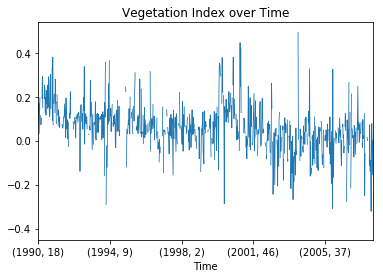

In [71]:
(sj_train_features
     .ndvi_ne
     .plot
     .line(lw=0.8))

plt.title('Vegetation Index over Time')
plt.xlabel('Time')

In [72]:
#sj_train_features.fillna(method='ffill', inplace=True)
sj_train_features= sj_train_features.interpolate()
#iq_train_features.fillna(method='ffill', inplace=True)
iq_train_features=iq_train_features.interpolate()

Text(0.5, 0, 'Time')

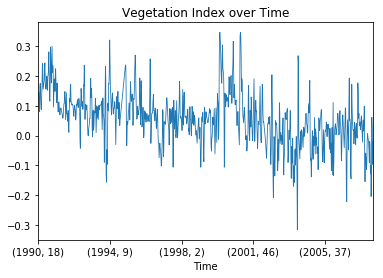

In [73]:
# Tail-rolling average transform
sj_train_features = sj_train_features.rolling(window=2)
sj_train_features = sj_train_features.mean()
iq_train_features = iq_train_features.rolling(window=2)
iq_train_features = iq_train_features.mean()
(sj_train_features
     .ndvi_ne
     .plot
     .line(lw=0.8))

plt.title('Vegetation Index over Time')
plt.xlabel('Time')

In [74]:
# Null check
pd.isnull(sj_train_features).any()

ndvi_ne                                  True
ndvi_nw                                  True
ndvi_se                                  True
ndvi_sw                                  True
precipitation_amt_mm                     True
reanalysis_air_temp_k                    True
reanalysis_avg_temp_k                    True
reanalysis_dew_point_temp_k              True
reanalysis_max_air_temp_k                True
reanalysis_min_air_temp_k                True
reanalysis_precip_amt_kg_per_m2          True
reanalysis_relative_humidity_percent     True
reanalysis_sat_precip_amt_mm             True
reanalysis_specific_humidity_g_per_kg    True
reanalysis_tdtr_k                        True
station_avg_temp_c                       True
station_diur_temp_rng_c                  True
station_max_temp_c                       True
station_min_temp_c                       True
station_precip_mm                        True
total_cases                              True
dtype: bool

Text(0.5, 0, 'Time')

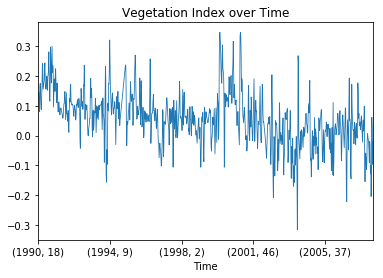

In [75]:
(sj_train_features
     .ndvi_ne
     .plot
     .line(lw=0.8))

plt.title('Vegetation Index over Time')
plt.xlabel('Time')

In [76]:
sj_train_features['total_cases'] = sj_train_labels.total_cases
iq_train_features['total_cases'] = iq_train_labels.total_cases

In [77]:
def preprocess_data(data_path, labels_path=None):
    # load data and set index to city, year, weekofyear
    df = pd.read_csv(data_path, index_col=[0, 1, 2])
    
    # select features we want
    features = ['reanalysis_specific_humidity_g_per_kg', 
                 'reanalysis_dew_point_temp_k', 
                 'station_max_temp_c',
                 'reanalysis_precip_amt_kg_per_m2']
    df = df[features]
    
    # Filling the rest using linear interpolation
    df.interpolate(inplace=True)

    #standardize
    scaler = StandardScaler()
    df[df.columns] = scaler.fit_transform(df)
  
    # remove_outliers
    df = df[(np.abs(stats.zscore(df)) < 5).all(axis=1)]

    # add labels to dataframe
    if labels_path:
        labels = pd.read_csv(labels_path, index_col=[0, 1, 2])
        df = df.join(labels)
    
    # separate san juan and iquitos
    sj = df.loc['sj']
    iq = df.loc['iq']
    
    # Smoothing (Simple Moving Average)
    sj = sj.rolling(window=10,min_periods=1)
    sj = sj.mean()
    #sj.fillna(method='ffill', inplace=True)
    iq = iq.rolling(window=10,min_periods=1)
    iq = iq.mean()
    #iq.fillna(method='ffill', inplace=True)
    
    return sj, iq

In [78]:
sj_train, iq_train = preprocess_data('/home/dinika/sem7/Dengue_Challenge/dataset2/dengue_features_train.csv',
                                    labels_path="/home/dinika/sem7/Dengue_Challenge/dataset2/dengue_labels_train.csv")

In [79]:
sj_train_subtrain = sj_train.head(800)
sj_train_subtest = sj_train.tail(sj_train.shape[0] - 800)

iq_train_subtrain = iq_train.head(400)
iq_train_subtest = iq_train.tail(iq_train.shape[0] - 400)

In [80]:
from statsmodels.tools import eval_measures
import statsmodels.formula.api as smf

def get_best_model(train, test):
    # Step 1: specify the form of the model
    model_formula = "total_cases ~ 1 + " \
                    "reanalysis_specific_humidity_g_per_kg + " \
                    "reanalysis_dew_point_temp_k + " \
                    "station_max_temp_c + " \
                    "reanalysis_precip_amt_kg_per_m2"
                
    grid = 10 ** np.arange(-12, -3, dtype=np.float64)
                    
    best_alpha = []
    best_score = 1000
        
    # Step 2: Find the best hyper parameter, alpha
    for alpha in grid:
        model = smf.glm(formula=model_formula,
                        data=train,
                        family=sm.families.NegativeBinomial(alpha=alpha))

        results = model.fit()
        predictions = results.predict(test).astype(int)
        score = eval_measures.meanabs(predictions, test.total_cases)

        if score < best_score:
            best_alpha = alpha
            best_score = score

    print('best alpha = ', best_alpha)
    print('best score = ', best_score)
            
    # Step 3: refit on entire dataset
    full_dataset = pd.concat([train, test])
    model = smf.glm(formula=model_formula,
                    data=full_dataset,
                    family=sm.families.NegativeBinomial(alpha=best_alpha))

    fitted_model = model.fit()
    #print (fitted_model.fittedvalues)
    return fitted_model
    
sj_best_model = get_best_model(sj_train_subtrain, sj_train_subtest)
iq_best_model = get_best_model(iq_train_subtrain, iq_train_subtest)


best alpha =  0.0001
best score =  20.261194029850746
best alpha =  1e-12
best score =  6.623076923076923


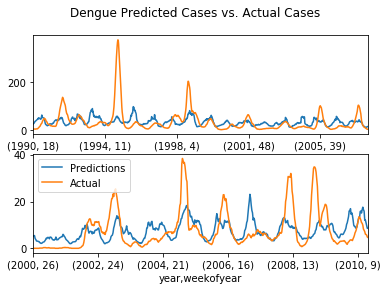

In [81]:
figs, axes = plt.subplots(nrows=2, ncols=1)

# plot sj
sj_train['fitted'] = sj_best_model.fittedvalues
sj_train.fitted.plot(ax=axes[0], label="Predictions")
sj_train.total_cases.plot(ax=axes[0], label="Actual")

# plot iq
iq_train['fitted'] = iq_best_model.fittedvalues
iq_train.fitted.plot(ax=axes[1], label="Predictions")
iq_train.total_cases.plot(ax=axes[1], label="Actual")

plt.suptitle("Dengue Predicted Cases vs. Actual Cases")
plt.legend()

In [82]:
from sklearn.metrics import mean_absolute_error
mae_sj = mean_absolute_error(sj_train['total_cases'], sj_train['fitted'])
mae_iq = mean_absolute_error(iq_train['total_cases'], iq_train['fitted'])
sj_cp = sj_train
full_set = sj_cp.append(iq_train)
mae = mean_absolute_error(full_set['total_cases'], full_set['fitted'])
print (mae_sj)
print (mae_iq)
print(mae)

25.678805833957423
5.076171535112913
18.337963702666862


In [83]:
sj_test, iq_test = preprocess_data('https://s3.amazonaws.com/drivendata/data/44/public/dengue_features_test.csv')

sj_predictions = sj_best_model.predict(sj_test).astype(int)
iq_predictions = iq_best_model.predict(iq_test).astype(int)
print (sj_predictions)
print (iq_predictions)

submission = pd.read_csv("https://s3.amazonaws.com/drivendata/data/44/public/submission_format.csv",
                         index_col=[0, 1, 2])
BenchmarkPath = '/home/dinika/sem7/Dengue_Challenge/Results/attempt_withMoreFeatures_benchmark_new.csv'
submission.total_cases = np.concatenate([sj_predictions, iq_predictions])
submission.to_csv(BenchmarkPath)
print ("DONE")

year  weekofyear
2008  18            48
      19            29
      20            28
      21            29
      22            29
      23            30
      24            28
      25            29
      26            29
      27            27
      28            25
      29            25
      30            25
      31            24
      32            25
      33            25
      34            28
      35            27
      36            30
      37            36
      38            38
      39            49
      40            54
      41            53
      42            54
      43            53
      44            47
      45            48
      46            41
      47            37
                    ..
2012  39            29
      40            29
      41            28
      42            29
      43            28
      44            29
      45            27
      46            31
      47            29
      48            29
      49            28
      50         

ValueError: Length of values does not match length of index